In [1]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import time
import itertools
import prince as pn
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import umap

C:\Users\nteut\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#https://www.kaggle.com/milesius/cpd-investigatory-stop-reports

# Import and clean data

In [3]:
#Import data

df2016 = pd.read_csv('01-JAN-2016_28-FEB-2017.csv')
df2016.drop('RD_NO', axis=1, inplace=True)

df2017 = pd.read_csv('29-FEB-2017_16-JAN-2018.csv')

df = pd.concat([df2016, df2017])
df_clean = df.copy()

#Remove columns with 0 or 1 unique values
df_clean.drop(['JUVENILE_I', 'WARD', 'RES_WARD', 'BUS_WARD', 'TYPE_CD', 'COMPLETION_I', 'OTHER_CONTRABAND_I', 
               'OTHER_CONTRABAND_DESCR', 'SEARCH_OTHER_CONTRABAND_I', 'SEARCH_OTHER_CONTRABAND_DESCR', 
               'CITED_VIOLATIONS_CD'], axis=1, inplace=True)

#Remove columns that are not useful/too many unique string values
df_clean.drop(['CONTACT_CARD_ID', 'CARD_NO', 'SUBMITTING_BEAT_CD', 'CLOTHING_DESCR', 'HOTSPOT_NO', 'EVENT_NO', 'MISSION_NO', 
               'CPD_UNIT_NO', 'CREATED_BY', 'CREATED_DATE', 'MODIFIED_BY', 'MODIFIED_DATE', 'AGE_TO', 'STREET_NO', 
               'STREET_DIRECTION_CD', 'APT_NO', 'STREET_NME', 'CITY', 'STATE_CD', 'ZIP_CD', 'HALF_ADDRESS_I', 'DISTRICT', 
               'SECTOR', 'BEAT', 'RES_DISTRICT', 'RES_SECTOR', 'RES_BEAT', 'BUS_DISTRICT', 'BUS_SECTOR', 'BUS_BEAT', 
               'SUBMITTING_UNIT', 'CONTACT_TYPE_DESCR', 'MAKE_DESCR', 'STYLE_DESCR', 'MODEL_DESCR', 'V_YEAR', 'COLOR_BOTTOM', 
               'FO_EMPLOYEE_ID', 'SO_EMPLOYEE_ID', 'SUPV_EMPLOYEE_ID', 'GANG', 'KNOWN_HANGOUT', 'FACTION_NAME', 
               'CONTACT_CARD_STATUS_CD', 'LOCATION_CD', 'OTHER_WEAPON_DESCR', 'OTHER_CON_SUB', 'OTHER_CON_SUB_AMT', 
               'SEARCH_OTHER_WEAPON_DESCR', 'SEARCH_OTHER_CON_SUB_DESCR', 'SEARCH_OTHER_CON_SUB_AMT', 'FACIAL_HAIR_CD', 
               'ENFORCEMENT_ID_NO', 'CANNABIS_INVENTORY_NO', 'COCAINE_INVENTORY_NO', 'HEROIN_INVENTORY_NO', 
               'OTHER_CON_SUB_INVENTORY_NO', 'FIREARM_INVENTORY_NO', 'OTHER_WEAPON_INVENTORY_NO', 'ALCOHOL_INVENTORY_NO', 
               'PARA_INVENTORY_NO', 'STOLEN_PROPERTY_INVENTORY_NO', 'S_CANNABIS_INVENTORY_NO', 'S_COCAINE_INVENTORY_NO', 
               'S_HEROIN_INVENTORY_NO', 'S_OTHER_CON_SUB_INVENTORY_NO', 'S_FIREARM_INVENTORY_NO', 
               'S_OTHER_WEAPON_INVENTORY_NO', 'S_ALCOHOL_INVENTORY_NO', 'S_PARA_INVENTORY_NO', 
               'S_STOLEN_PROPERTY_INVENTORY_NO', 'GANG_OTHER', 'OTHER_DESCR', 'OTHER_INVENTORY_NO', 'S_OTHER_DESCR', 
               'S_OTHER_INVENTORY_NO', 'NAME', 'CONTACT_DATE'], axis=1, inplace=True)

#Remove redacted entries
for col in df_clean.columns:
    df_clean = df_clean[(df_clean[col] != 'REDACTED')]

C:\Users\nteut\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,4,11,13,14,16,18,19,22,23,29,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,59,63,64,65,66,72,74,75,100,102,103,104,110,111,117,119,120,121,132,134,138,139,140,141,142,143,144,146,148,150,152,153,154,155,156,157,159,161,163,164,166,169) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\nteut\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,4,10,12,13,15,17,18,21,22,28,34,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,58,62,63,64,71,73,74,99,101,102,103,109,110,116,118,119,120,121,122,131,133,137,138,139,140,141,142,143,145,146,147,148,149,151,152,153,154,155,156,158,160,162,165,168) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#Binarize appropriate columns, replacing null values with 0

df_clean['NAME_VERIFIED_I'] = np.where(df_clean['NAME_VERIFIED_I'] == 'Y', 1, 0)
df_clean['HANDCUFFED_I'] = np.where(df_clean['HANDCUFFED_I'] == 'Y', 1, 0)
df_clean['VEHICLE_INVOLVED_I'] = np.where(df_clean['VEHICLE_INVOLVED_I'] == 'Y', 1, 0)
df_clean['GANG_LOOKOUT_I'] = np.where(df_clean['GANG_LOOKOUT_I'] == 'Y', 1, 0)
df_clean['GANG_SECURITY_I'] = np.where(df_clean['GANG_SECURITY_I'] == 'Y', 1, 0)
df_clean['INTIMIDATION_I'] = np.where(df_clean['INTIMIDATION_I'] == 'Y', 1, 0)
df_clean['SUSPECT_NARCOTIC_ACTIVITY_I'] = np.where(df_clean['SUSPECT_NARCOTIC_ACTIVITY_I'] == 'Y', 1, 0)
df_clean['ENFORCEMENT_ACTION_TAKEN_I'] = np.where(df_clean['ENFORCEMENT_ACTION_TAKEN_I'] == 'Y', 1, 0)
df_clean['INDICATIVE_DRUG_TRANSACTION_I'] = np.where(df_clean['INDICATIVE_DRUG_TRANSACTION_I'] == 'Y', 1, 0)
df_clean['INDICATIVE_CASING_I'] = np.where(df_clean['INDICATIVE_CASING_I'] == 'Y', 1, 0)
df_clean['FITS_DESCRIPTION_I'] = np.where(df_clean['FITS_DESCRIPTION_I'] == 'Y', 1, 0)
df_clean['PROXIMITY_TO_CRIME_I'] = np.where(df_clean['PROXIMITY_TO_CRIME_I'] == 'Y', 1, 0)
df_clean['FITS_DESCRIPTION_OFFENDER_I'] = np.where(df_clean['FITS_DESCRIPTION_OFFENDER_I'] == 'Y', 1, 0)
df_clean['GANG_NARCOTIC_RELATED_I'] = np.where(df_clean['GANG_NARCOTIC_RELATED_I'] == 'Y', 1, 0)
df_clean['OTHER_FACTOR_I'] = np.where(df_clean['OTHER_FACTOR_I'] == 'Y', 1, 0)
df_clean['PAT_DOWN_I'] = np.where(df_clean['PAT_DOWN_I'] == 'Y', 1, 0)
df_clean['PAT_DOWN_CONSENT_I'] = np.where(df_clean['PAT_DOWN_CONSENT_I'] == 'Y', 1, 0)
df_clean['PAT_DOWN_RECEIPT_GIVEN_I'] = np.where(df_clean['PAT_DOWN_RECEIPT_GIVEN_I'] == 'Y', 1, 0)
df_clean['VERBAL_THREATS_I'] = np.where(df_clean['VERBAL_THREATS_I'] == 'Y', 1, 0)
df_clean['KNOWLEDGE_OF_PRIOR_I'] = np.where(df_clean['KNOWLEDGE_OF_PRIOR_I'] == 'Y', 1, 0)
df_clean['ACTIONS_INDICATIVE_VIOLENCE_I'] = np.where(df_clean['ACTIONS_INDICATIVE_VIOLENCE_I'] == 'Y', 1, 0)
df_clean['VIOLENT_CRIME_I'] = np.where(df_clean['VIOLENT_CRIME_I'] == 'Y', 1, 0)
df_clean['SUSPICIOUS_OBJECT_I'] = np.where(df_clean['SUSPICIOUS_OBJECT_I'] == 'Y', 1, 0)
df_clean['OTHER_REASONABLE_SUSPICION_I'] = np.where(df_clean['OTHER_REASONABLE_SUSPICION_I'] == 'Y', 1, 0)
df_clean['WEAPON_OR_CONTRABAND_FOUND_I'] = np.where(df_clean['WEAPON_OR_CONTRABAND_FOUND_I'] == 'Y', 1, 0)
df_clean['FIREARM_I'] = np.where(df_clean['FIREARM_I'] == 'Y', 1, 0)
df_clean['COCAINE_I'] = np.where(df_clean['COCAINE_I'] == 'Y', 1, 0)
df_clean['HEROIN_I'] = np.where(df_clean['HEROIN_I'] == 'Y', 1, 0)
df_clean['OTHER_WEAPON_I'] = np.where(df_clean['OTHER_WEAPON_I'] == 'Y', 1, 0)
df_clean['CANNABIS_I'] = np.where(df_clean['CANNABIS_I'] == 'Y', 1, 0)
df_clean['OTHER_CON_SUB_I'] = np.where(df_clean['OTHER_CON_SUB_I'] == 'Y', 1, 0)
df_clean['SEARCH_I'] = np.where(df_clean['SEARCH_I'] == 'Y', 1, 0)
df_clean['SEARCH_CONSENT_I'] = np.where(df_clean['SEARCH_CONSENT_I'] == 'Y', 1, 0)
df_clean['SEARCH_CONTRABAND_FOUND_I'] = np.where(df_clean['SEARCH_CONTRABAND_FOUND_I'] == 'Y', 1, 0)
df_clean['SEARCH_FIREARM_I'] = np.where(df_clean['SEARCH_FIREARM_I'] == 'Y', 1, 0)
df_clean['SEARCH_COCAINE_I'] = np.where(df_clean['SEARCH_COCAINE_I'] == 'Y', 1, 0)
df_clean['SEARCH_HEROIN_I'] = np.where(df_clean['SEARCH_HEROIN_I'] == 'Y', 1, 0)
df_clean['SEARCH_OTHER_WEAPON_I'] = np.where(df_clean['SEARCH_OTHER_WEAPON_I'] == 'Y', 1, 0)
df_clean['SEARCH_CANNABIS_I'] = np.where(df_clean['SEARCH_CANNABIS_I'] == 'Y', 1, 0)
df_clean['SEARCH_OTHER_CON_SUB_I'] = np.where(df_clean['SEARCH_OTHER_CON_SUB_I'] == 'Y', 1, 0)
df_clean['BODY_CAMERA_I'] = np.where(df_clean['BODY_CAMERA_I'] == 'Y', 1, 0)
df_clean['CAR_CAMERA_I'] = np.where(df_clean['CAR_CAMERA_I'] == 'Y', 1, 0)
df_clean['VEHICLE_STOPPED_I'] = np.where(df_clean['VEHICLE_STOPPED_I'] == 'Y', 1, 0)
df_clean['INFORMATION_REFUSED_I'] = np.where(df_clean['INFORMATION_REFUSED_I'] == 'Y', 1, 0)
df_clean['GANG_OTHER_I'] = np.where(df_clean['GANG_OTHER_I'] == 'Y', 1, 0)
df_clean['ALCOHOL_I'] = np.where(df_clean['ALCOHOL_I'] == 'Y', 1, 0)
df_clean['PARA_I'] = np.where(df_clean['PARA_I'] == 'Y', 1, 0)
df_clean['STOLEN_PROPERTY_I'] = np.where(df_clean['STOLEN_PROPERTY_I'] == 'Y', 1, 0)
df_clean['SEARCH_PROPERTY_I'] = np.where(df_clean['SEARCH_PROPERTY_I'] == 'Y', 1, 0)
df_clean['S_ALCOHOL_I'] = np.where(df_clean['S_ALCOHOL_I'] == 'Y', 1, 0)
df_clean['S_PARA_I'] = np.where(df_clean['S_PARA_I'] == 'Y', 1, 0)
df_clean['S_STOLEN_PROPERTY_I'] = np.where(df_clean['S_STOLEN_PROPERTY_I'] == 'Y', 1, 0)
df_clean['S_OTHER_I'] = np.where(df_clean['S_OTHER_I'] == 'Y', 1, 0)

In [5]:
#Convert data types of numeric columns

df_clean['CONTACT_HOUR'] = pd.to_numeric(df_clean['CONTACT_HOUR'], errors='coerce')
df_clean['AGE'] = pd.to_numeric(df_clean['AGE'], errors='coerce')
df_clean['HEIGHT'] = pd.to_numeric(df_clean['HEIGHT'], errors='coerce')
df_clean['WEIGHT'] = pd.to_numeric(df_clean['WEIGHT'], errors='coerce')
df_clean['AREA'] = pd.to_numeric(df_clean['AREA'], errors='coerce')
df_clean['RES_AREA'] = pd.to_numeric(df_clean['RES_AREA'], errors='coerce')
df_clean['BUS_AREA'] = pd.to_numeric(df_clean['BUS_AREA'], errors='coerce')
df_clean['DISPERSAL_TIME'] = pd.to_numeric(df_clean['DISPERSAL_TIME'], errors='coerce')
df_clean['NUMBER_OF_PERSONS_DISPERSED'] = pd.to_numeric(df_clean['NUMBER_OF_PERSONS_DISPERSED'], errors='coerce')

In [6]:
#Fill null values with 0 when applicable

df_clean['DISPERSAL_TIME'].fillna(0, inplace=True)
df_clean['NUMBER_OF_PERSONS_DISPERSED'].fillna(0, inplace=True)

In [7]:
#Fill null values with unknown codes

df_clean['SEX_CODE_CD'].fillna('X', inplace=True)
df_clean['RACE_CODE_CD'].fillna('U', inplace=True)
df_clean['BUILD_CODE_CD'].fillna('XXX', inplace=True)
df_clean['EYE_COLOR_CODE_CD'].fillna('XXX', inplace=True)
df_clean['HAIR_COLOR_CODE_CD'].fillna('XXX', inplace=True)
df_clean['HAIR_STYLE_CODE_CD'].fillna('XXX', inplace=True)
df_clean['COMPLEXION_CODE_CD'].fillna('XXX', inplace=True)
df_clean['EVENT_ASSIGNEED_BY_CD'].fillna('OTH', inplace=True)
df_clean['ENFORCEMENT_TYPE_CD'].fillna('OTH', inplace=True)
df_clean['MAKE_CD'].fillna('XXX', inplace=True)
df_clean['STYLE_CD'].fillna('XX', inplace=True)
df_clean['COLOR_TOP'].fillna('XXX', inplace=True)

In [8]:
#Reformat mixed nmeric-string object variables

df_clean['COCAINE_AMOUNT'] = df_clean['COCAINE_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')
df_clean['HEROIN_AMOUNT'] = df_clean['HEROIN_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')
df_clean['CANNABIS_AMOUNT'] = df_clean['CANNABIS_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')
df_clean['SEARCH_COCAINE_AMOUNT'] = df_clean['SEARCH_COCAINE_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')
df_clean['SEARCH_HEROIN_AMOUNT'] = df_clean['SEARCH_HEROIN_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')
df_clean['SEARCH_CANNABIS_AMOUNT'] = df_clean['SEARCH_CANNABIS_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')

#Convert reformatted strings to numeric
df_clean['COCAINE_AMOUNT'] = pd.to_numeric(df_clean['COCAINE_AMOUNT'], errors='coerce')
df_clean['HEROIN_AMOUNT'] = pd.to_numeric(df_clean['HEROIN_AMOUNT'], errors='coerce')
df_clean['CANNABIS_AMOUNT'] = pd.to_numeric(df_clean['CANNABIS_AMOUNT'], errors='coerce')
df_clean['SEARCH_COCAINE_AMOUNT'] = pd.to_numeric(df_clean['SEARCH_COCAINE_AMOUNT'], errors='coerce')
df_clean['SEARCH_HEROIN_AMOUNT'] = pd.to_numeric(df_clean['SEARCH_HEROIN_AMOUNT'], errors='coerce')
df_clean['SEARCH_CANNABIS_AMOUNT'] = pd.to_numeric(df_clean['SEARCH_CANNABIS_AMOUNT'], errors='coerce')

#Fill null values with 0
df_clean['COCAINE_AMOUNT'].fillna(0, inplace=True)
df_clean['HEROIN_AMOUNT'].fillna(0, inplace=True)
df_clean['CANNABIS_AMOUNT'].fillna(0, inplace=True)
df_clean['SEARCH_COCAINE_AMOUNT'].fillna(0, inplace=True)
df_clean['SEARCH_HEROIN_AMOUNT'].fillna(0, inplace=True)
df_clean['SEARCH_CANNABIS_AMOUNT'].fillna(0, inplace=True)

In [9]:
#Drop remaining null values

df_clean.dropna(inplace=True)

In [10]:
#Subsample data for speed of testing

df_clean_test = df_clean.sample(frac=0.1, random_state=123).reset_index()

In [11]:
#Separate out categorical and numeric variables

df_num = df_clean_test[['CONTACT_HOUR', 'AGE', 'HEIGHT', 'WEIGHT', 'DISPERSAL_TIME', 'NUMBER_OF_PERSONS_DISPERSED', 
                  'COCAINE_AMOUNT', 'HEROIN_AMOUNT', 'CANNABIS_AMOUNT', 'SEARCH_COCAINE_AMOUNT', 'SEARCH_HEROIN_AMOUNT', 
                  'SEARCH_CANNABIS_AMOUNT']].copy()
df_cat = df_clean_test.drop(['CONTACT_HOUR', 'AGE', 'HEIGHT', 'WEIGHT', 'DISPERSAL_TIME', 'NUMBER_OF_PERSONS_DISPERSED', 
                  'COCAINE_AMOUNT', 'HEROIN_AMOUNT', 'CANNABIS_AMOUNT', 'SEARCH_COCAINE_AMOUNT', 'SEARCH_HEROIN_AMOUNT', 
                  'SEARCH_CANNABIS_AMOUNT'], axis=1)

In [12]:
#Scale numerical variables

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)

In [13]:
def mapping(num):
    if num == 0:
        return 'zero'
    elif num == 1:
        return 'one'
    elif num == 2:
        return 'two'
    elif num == 3:
        return 'three'
    elif num == 4:
        return 'four'
    elif num == 5:
        return 'five'

# Visualize numerical data with initial K-means clustering

In [14]:
# #Perform K-Means on numerical variables with 3 clusters

# start_time = time.time()
# k_means_3cls = KMeans(n_clusters=3)
# y_pred_3cls = k_means_3cls.fit_predict(df_scaled)
# print("--- %s seconds ---" % (time.time() - start_time))

# predictions_3cls = pd.DataFrame(y_pred_3cls, columns=['y_pred'])
# predictions_3cls['y_pred2'] = predictions_3cls['y_pred'].apply(lambda x: mapping(x))

# for i in predictions_3cls['y_pred2'].unique():
#     print(predictions_3cls['y_pred2'][(predictions_3cls['y_pred2'] == i)].count())

In [15]:
# #Visualize with first 2 components of PCA

# start_time = time.time()
# pca_raw = PCA(n_components=2)
# pca_data_raw = pca_raw.fit_transform(df_scaled)
# print("--- %s seconds ---" % (time.time() - start_time))

# sns.scatterplot(pca_data_raw[:,0], pca_data_raw[:,1], hue=predictions_3cls['y_pred2'])
# print("--- %s seconds ---" % (time.time() - start_time))

In [16]:
# #Visualize with first 2 components of UMAP

# start_time = time.time()
# umap_model_raw = umap.UMAP(n_neighbors=15,
#                       min_dist=0.1,
#                       metric='correlation')
# umap_results_raw = umap_model_raw.fit_transform(df_scaled)
# print("--- %s seconds ---" % (time.time() - start_time))

# sns.scatterplot(umap_results_raw[:,0], umap_results_raw[:,1], hue=predictions_3cls['y_pred2'])
# print("--- %s seconds ---" % (time.time() - start_time))

In [17]:
# #Perform K-Means on numerical variables with 6 clusters

# start_time = time.time()
# k_means_6cls = KMeans(n_clusters=6)
# y_pred_6cls = k_means_6cls.fit_predict(df_scaled)
# print("--- %s seconds ---" % (time.time() - start_time))

# predictions_6cls = pd.DataFrame(y_pred_6cls, columns=['y_pred'])
# predictions_6cls['y_pred2'] = predictions_6cls['y_pred'].apply(lambda x: mapping(x))

# for i in predictions_6cls['y_pred2'].unique():
#     print(predictions_6cls['y_pred2'][(predictions_6cls['y_pred2'] == i)].count())

In [18]:
# #Visualize with first 2 components of PCA

# start_time = time.time()
# sns.scatterplot(pca_data_raw[:,0], pca_data_raw[:,1], hue=predictions_6cls['y_pred2'])
# print("--- %s seconds ---" % (time.time() - start_time))

In [19]:
# #Visualize with first 2 components of UMAP

# start_time = time.time()
# sns.scatterplot(umap_results_raw[:,0], umap_results_raw[:,1], hue=predictions_6cls['y_pred2'])
# print("--- %s seconds ---" % (time.time() - start_time))

# Visualize numerical data with dimensionality reduction

In [20]:
# #Perform PCA on numerical variables for dimensionality reduction, perform K-Means on resulting components

# start_time = time.time()
# pca_dimred = PCA(n_components=6)
# pca_data_dimred = pca_dimred.fit_transform(df_scaled)
# print("--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()
# k_means_pcadimred_6cls = KMeans(n_clusters=6)
# y_pred_pcadimred_6cls = k_means_pcadimred_6cls.fit_predict(pca_data_dimred)

# print("--- %s seconds ---" % (time.time() - start_time))

# predictions_pcadimred_6cls = pd.DataFrame(y_pred_pcadimred_6cls, columns=['y_pred'])
# predictions_pcadimred_6cls['y_pred2'] = predictions_pcadimred_6cls['y_pred'].apply(lambda x: mapping(x))
# for i in predictions_pcadimred_6cls['y_pred2'].unique():
#     print(predictions_pcadimred_6cls['y_pred2'][(predictions_pcadimred_6cls['y_pred2'] == i)].count())

In [21]:
# #Visualize with first 2 components of PCA

# start_time = time.time()
# sns.scatterplot(pca_data_raw[:,0], pca_data_raw[:,1], hue=predictions_pcadimred_6cls['y_pred2'])
# print("--- %s seconds ---" % (time.time() - start_time))

In [22]:
# #Visualize with first 2 components of UMAP

# start_time = time.time()
# sns.scatterplot(umap_results_raw[:,0], umap_results_raw[:,1], hue=predictions_pcadimred_6cls['y_pred2'])
# print("--- %s seconds ---" % (time.time() - start_time))

In [23]:
# #Perform UMAP on numerical variables for dimensionality reduction, perform K-Means on resulting components

# start_time = time.time()
# umap_results_dimred = umap_results_raw
# print("--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()
# k_means_umapdimred_6cls = KMeans(n_clusters=6)
# y_pred_umapdimred_6cls = k_means_umapdimred_6cls.fit_predict(umap_results_dimred)
# print("--- %s seconds ---" % (time.time() - start_time))

# predictions_umapdimred_6cls = pd.DataFrame(y_pred_umapdimred_6cls, columns=['y_pred'])
# predictions_umapdimred_6cls['y_pred2'] = predictions_umapdimred_6cls['y_pred'].apply(lambda x: mapping(x))
# for i in predictions_umapdimred_6cls['y_pred2'].unique():
#     print(predictions_umapdimred_6cls['y_pred2'][(predictions_umapdimred_6cls['y_pred2'] == i)].count())

In [24]:
# #Visualize with first 2 components of UMAP

# start_time = time.time()
# sns.scatterplot(umap_results_raw[:,0], umap_results_raw[:,1], hue=predictions_umapdimred_6cls['y_pred2'])
# print("--- %s seconds ---" % (time.time() - start_time))

# Convert categorical data to numerical data with MCA

In [25]:
#Perform MCA on categorical variables for dimensionality reduction, perform K-Means on resulting components

start_time = time.time()
mca = pn.MCA(n_components=10, n_iter=5, copy=True, check_input=True, engine='sklearn')
df_cat_mca_raw = mca.fit_transform(df_cat)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
k_means_mca_6cls = KMeans(n_clusters=6)
y_pred_mca_6cls = k_means_mca_6cls.fit_predict(df_cat_mca_raw)
print("--- %s seconds ---" % (time.time() - start_time))

predictions_mca_6cls = pd.DataFrame(y_pred_mca_6cls, columns=['y_pred'])
predictions_mca_6cls['y_pred2'] = predictions_mca_6cls['y_pred'].apply(lambda x: mapping(x))
for i in predictions_mca_6cls['y_pred2'].unique():
    print(predictions_mca_6cls['y_pred2'][(predictions_mca_6cls['y_pred2'] == i)].count())

--- 2.043524742126465 seconds ---
--- 0.26429033279418945 seconds ---
29560
1
2
1
1
1


In [26]:
# #Visualize with first 2 components of PCA

# start_time = time.time()
# pca_mca = PCA(n_components=2)
# pca_data_mca = pca_mca.fit_transform(df_cat_mca_raw)
# print("--- %s seconds ---" % (time.time() - start_time))

# sns.scatterplot(pca_data_mca[:,0], pca_data_mca[:,1], hue=predictions_mca_6cls['y_pred2'])
# print("--- %s seconds ---" % (time.time() - start_time))

In [27]:
#Scale categorical variables

df_cat_mca_scaled = scaler.fit_transform(df_cat_mca_raw)

In [28]:
df_new = pd.concat([pd.DataFrame(df_scaled), pd.DataFrame(df_cat_mca_scaled)], axis=1)
df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,0,1,2,3,4,5,6,7,8,9
0,0.030899,-1.142158,-0.244393,-0.288453,-0.258151,-0.225135,-0.015792,-0.016143,-0.040141,-0.033061,...,-0.026921,0.010593,0.003484,-0.000481,0.010405,0.005582,-0.018112,-0.003502,-0.011929,-0.021909
1,-0.124468,-0.607862,-0.244393,-0.529891,-0.258151,-0.225135,-0.015792,-0.016143,-0.040141,-0.033061,...,-0.014445,-0.003351,-0.003060,-0.001685,-0.029082,-0.007649,0.025356,-0.001795,0.016154,0.047205
2,0.186266,-0.073566,1.250338,0.194423,-0.258151,-0.225135,-0.015792,-0.016143,-0.040141,-0.033061,...,-0.034424,0.016812,0.012055,0.011682,0.008359,0.016387,0.007610,0.000245,0.010223,-0.010837
3,0.341633,-0.760518,-0.182112,-0.529891,-0.258151,-0.225135,-0.015792,-0.016143,-0.040141,-0.033061,...,-0.031178,0.013497,0.011053,0.010448,0.012308,0.023468,0.022356,0.001230,0.028561,0.017360
4,0.807733,-0.607862,1.203627,1.039455,-0.258151,-0.225135,-0.015792,-0.016143,-0.040141,-0.033061,...,-0.032240,0.015030,0.011736,0.011611,0.006505,0.020642,0.017460,-0.001456,0.018203,-0.005372


# Visualize combined data

In [29]:
# #Visualize with first 2 components of PCA

# start_time = time.time()
# pca_total = PCA(n_components=2)
# pca_data_total = pca_total.fit_transform(df_new)
# print("--- %s seconds ---" % (time.time() - start_time))

# sns.scatterplot(pca_data_total[:,0], pca_data_total[:,1])
# print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\nteut\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


--- 33.65770125389099 seconds ---
--- 33.74347233772278 seconds ---


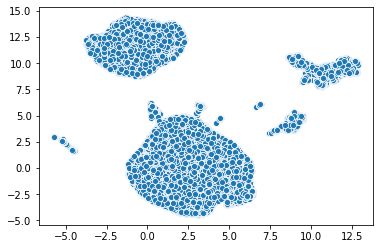

In [30]:
#Visualize with first 2 components of UMAP

start_time = time.time()
umap_model_total = umap.UMAP(n_neighbors=30,
                                    n_components=3,
                                    min_dist=0.3,
                                    metric='correlation')
umap_results_total = umap_model_total.fit_transform(df_new)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(umap_results_total[:,0], umap_results_total[:,1])
print("--- %s seconds ---" % (time.time() - start_time))

In [31]:
# #Perform PCA on all variables for dimensionality reduction, perform K-Means on resulting components

# start_time = time.time()
# pca_total_dimred = PCA(n_components=6)
# pca_data_total_dimred = pca_total_dimred.fit_transform(df_new)
# print("--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()
# k_means_pca_totaldimred_6cls = KMeans(n_clusters=6)
# y_pred_pca_totaldimred_6cls = k_means_pca_totaldimred_6cls.fit_predict(pca_data_total_dimred)

# print("--- %s seconds ---" % (time.time() - start_time))

# predictions_pca_totaldimred_6cls = pd.DataFrame(y_pred_pca_totaldimred_6cls, columns=['y_pred'])
# predictions_pca_totaldimred_6cls['y_pred2'] = predictions_pca_totaldimred_6cls['y_pred'].apply(lambda x: mapping(x))
# for i in predictions_pca_totaldimred_6cls['y_pred2'].unique():
#     print(predictions_pca_totaldimred_6cls['y_pred2'][(predictions_pca_totaldimred_6cls['y_pred2'] == i)].count())

In [32]:
# #Visualize with first 2 components of UMAP

# start_time = time.time()
# sns.scatterplot(umap_results_total[:,0], umap_results_total[:,1], hue=predictions_pca_totaldimred_6cls['y_pred2'])
# print("--- %s seconds ---" % (time.time() - start_time))

# Clustering analysis

## K-means clustering

In [33]:
# #Calculate silhouette score for various numbers of clusters with K-means

# start_time = time.time()
# for n in range(2, 10):
#     k_means_umap_totaldimred_temp = KMeans(n_clusters=n)
#     y_pred_umap_totaldimred_temp = k_means_umap_totaldimred_temp.fit_predict(umap_results_total)

#     predictions_umap_totaldimred_temp = pd.DataFrame(y_pred_umap_totaldimred_temp, columns=['y_pred'])
    
#     print('For {} clusters:'.format(n))
#     print('The silhouette score is {}'.format(silhouette_score(umap_results_total, predictions_umap_totaldimred_temp['y_pred'], metric='euclidean')))
#     print("--- %s seconds ---" % (time.time() - start_time))
#     print()

In [34]:
#Perform K-Means on resulting components with optimal number of clusters

start_time = time.time()
k_means_umap_totaldimred_4cls = KMeans(n_clusters=4)
y_pred_umap_totaldimred_4cls = k_means_umap_totaldimred_4cls.fit_predict(umap_results_total)
print("--- %s seconds ---" % (time.time() - start_time))

predictions_umap_totaldimred_4cls = pd.DataFrame(y_pred_umap_totaldimred_4cls, columns=['y_pred'])
predictions_umap_totaldimred_4cls['y_pred2'] = predictions_umap_totaldimred_4cls['y_pred'].apply(lambda x: mapping(x))
for i in predictions_umap_totaldimred_4cls['y_pred2'].unique():
    print(predictions_umap_totaldimred_4cls['y_pred2'][(predictions_umap_totaldimred_4cls['y_pred2'] == i)].count())

--- 0.45477867126464844 seconds ---
11006
5976
10245
2339


--- 0.13994717597961426 seconds ---


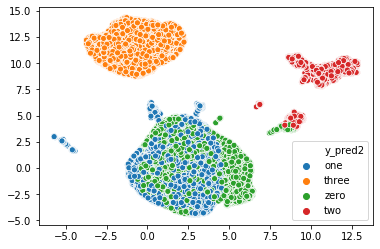

In [35]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_results_total[:,0], umap_results_total[:,1], hue=predictions_umap_totaldimred_4cls['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.12667369842529297 seconds ---


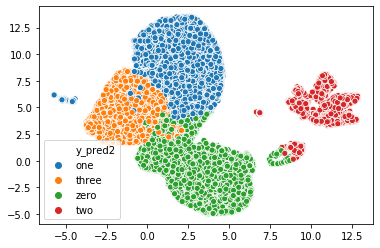

In [36]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_results_total[:,0], umap_results_total[:,2], hue=predictions_umap_totaldimred_4cls['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.2074744701385498 seconds ---


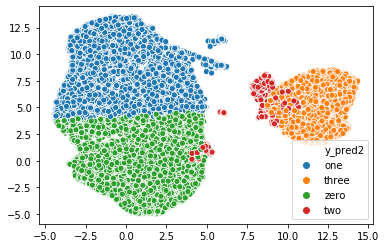

In [37]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_results_total[:,1], umap_results_total[:,2], hue=predictions_umap_totaldimred_4cls['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

In [38]:
#Calculate silhouette score

print('The silhouette score is {}'.format(silhouette_score(umap_results_total, predictions_umap_totaldimred_4cls['y_pred'], metric='euclidean')))

The silhouette score is 0.5205152034759521


## Hierarchical clustering

In [39]:
# #Calculate silhouette score for various numbers of clusters with hierarchical clustering

# start_time = time.time()
# for n in range(2, 10):
#     agg_cluster_temp = AgglomerativeClustering(linkage='complete', 
#                                       affinity='cosine',
#                                       n_clusters=n,
#                                               compute_full_tree=False)
#     y_pred_hier_temp = agg_cluster_temp.fit_predict(umap_results_total)

#     predictions_hier_temp = pd.DataFrame(y_pred_hier_temp, columns=['y_pred'])
    
#     print('For {} clusters:'.format(n))
#     print('The silhouette score is {}'.format(silhouette_score(umap_results_total, predictions_hier_temp['y_pred'], metric='euclidean')))
#     print("--- %s seconds ---" % (time.time() - start_time))
#     print()

In [40]:
# #Perform hierarchical clustering on resulting components with optimal number of clusters

# start_time = time.time()
# agg_cluster_4 = AgglomerativeClustering(linkage='complete', 
#                                       affinity='cosine',
#                                       n_clusters=4)

# y_pred_hier_4 = agg_cluster_4.fit_predict(umap_results_total)
# print("--- %s seconds ---" % (time.time() - start_time))

# predictions_hier_4 = pd.DataFrame(y_pred_hier_4, columns=['y_pred'])
# predictions_hier_4['y_pred2'] = predictions_hier_4['y_pred'].apply(lambda x: mapping(x))
# for i in predictions_hier_4['y_pred2'].unique():
#     print(predictions_hier_4['y_pred2'][(predictions_hier_4['y_pred2'] == i)].count())

In [41]:
# #Visualize with first 2 components of UMAP

# start_time = time.time()
# sns.scatterplot(umap_results_total[:,0], umap_results_total[:,1], hue=predictions_hier_4['y_pred2'])
# print("--- %s seconds ---" % (time.time() - start_time))

In [42]:
# #Visualize with first 2 components of UMAP

# start_time = time.time()
# sns.scatterplot(umap_results_total[:,0], umap_results_total[:,2], hue=predictions_hier_4['y_pred2'])
# print("--- %s seconds ---" % (time.time() - start_time))

In [43]:
# #Visualize with first 2 components of UMAP

# start_time = time.time()
# sns.scatterplot(umap_results_total[:,1], umap_results_total[:,2], hue=predictions_hier_4['y_pred2'])
# print("--- %s seconds ---" % (time.time() - start_time))

In [44]:
# #Calculate silhouette score

# print('The silhouette score is {}'.format(silhouette_score(umap_results_total, predictions_hier_4['y_pred'], metric='euclidean')))

## DBSCAN clustering

In [45]:
# #Calculate silhouette score for various values of epsilon with DBSCAN

# start_time = time.time()
# for i in range(1, 5):
#     dbscan_cluster_temp = DBSCAN(eps=i, min_samples=5)

#     y_pred_dbscan_temp = dbscan_cluster_temp.fit_predict(umap_results_total)

#     predictions_dbscan_temp = pd.DataFrame(y_pred_dbscan_temp, columns=['y_pred'])
    
#     print('For an epsilon of {}'.format(i))
#     print('The silhouette score is {}'.format(silhouette_score(umap_results_total, predictions_dbscan_temp['y_pred'], metric='euclidean')))
#     print("--- %s seconds ---" % (time.time() - start_time))
#     print()

In [46]:
# #Perform DBSCAN on resulting components with optimal epsilon

# start_time = time.time()
# dbscan_cluster = DBSCAN(eps=2, min_samples=5)

# y_pred_dbscan = dbscan_cluster.fit_predict(umap_results_total)
# print("--- %s seconds ---" % (time.time() - start_time))

# predictions_dbscan = pd.DataFrame(y_pred_dbscan, columns=['y_pred'])
# predictions_dbscan['y_pred2'] = predictions_dbscan['y_pred'].apply(lambda x: mapping(x))
# for i in predictions_dbscan['y_pred2'].unique():
#     print(predictions_dbscan['y_pred2'][(predictions_dbscan['y_pred2'] == i)].count())

In [47]:
# #Visualize with first 2 components of UMAP

# start_time = time.time()
# sns.scatterplot(umap_results_total[:,0], umap_results_total[:,1], hue=predictions_dbscan['y_pred2'])
# print("--- %s seconds ---" % (time.time() - start_time))

In [48]:
# #Visualize with first 2 components of UMAP

# start_time = time.time()
# sns.scatterplot(umap_results_total[:,0], umap_results_total[:,2], hue=predictions_dbscan['y_pred2'])
# print("--- %s seconds ---" % (time.time() - start_time))

In [49]:
# #Visualize with first 2 components of UMAP

# start_time = time.time()
# sns.scatterplot(umap_results_total[:,1], umap_results_total[:,2], hue=predictions_dbscan['y_pred2'])
# print("--- %s seconds ---" % (time.time() - start_time))

In [50]:
# #Calculate silhouette score

# print('The silhouette score is {}'.format(silhouette_score(umap_results_total, predictions_dbscan['y_pred'], metric='euclidean')))

### K-means clustering with 4 clusters determined to be optimal clustering method

## Visually, there is no reason to distinguish between cluster 0 and cluster 1, therefore we will combine these two clusters

# Analyze clusters

In [61]:
df_clean_test['Cluster'] = predictions_umap_totaldimred_4cls['y_pred']
df_clean_test.loc[df_clean_test['Cluster'] == 1, 'Cluster'] = 0

In [62]:
categorical = list(df_clean_test.select_dtypes(include='object').columns)
categorical.append('AREA')
categorical.append('RES_AREA')
categorical.append('BUS_AREA')

df_clean_test = pd.get_dummies(data=df_clean_test, columns=categorical)
df_clean_test.columns

KeyError: "None of [Index(['AREA', 'RES_AREA', 'BUS_AREA'], dtype='object')] are in the [columns]"

In [63]:
df_clean_0 = df_clean_test[(df_clean_test['Cluster'] == 0)]
df_clean_1 = df_clean_test[(df_clean_test['Cluster'] == 2)]
df_clean_2 = df_clean_test[(df_clean_test['Cluster'] == 3)]


In [64]:
df_clean_0.describe()

,index,CONTACT_HOUR,NAME_VERIFIED_I,AGE,HEIGHT,WEIGHT,HANDCUFFED_I,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,...,AREA_2,AREA_3,RES_AREA_0,RES_AREA_1,RES_AREA_2,RES_AREA_3,BUS_AREA_0,BUS_AREA_1,BUS_AREA_2,BUS_AREA_3
count,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,...,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000
mean,87802.875771,14.693097,0.377159,32.902358,506.211378,165.508729,0.016423,0.350572,0.259847,0.000329,...,0.260600,0.379747,0.150487,0.306621,0.229495,0.313397,0.993130,0.003106,0.001035,0.002729
std,48071.606053,6.545962,0.484687,13.112190,27.290231,35.836785,0.127098,0.477160,21.901326,0.024732,...,0.438972,0.485335,0.357557,0.461101,0.420518,0.463885,0.082604,0.055644,0.032159,0.052172
min,5.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48333.000000,11.000000,0.000000,22.000000,506.000000,145.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,85326.000000,16.000000,0.000000,29.000000,508.000000,160.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,122965.000000,20.000000,1.000000,42.000000,509.000000,180.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,188440.000000,23.000000,1.000000,91.000000,608.000000,602.000000,1.000000,1.000000,1930.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
df_clean_1.describe()

,index,CONTACT_HOUR,NAME_VERIFIED_I,AGE,HEIGHT,WEIGHT,HANDCUFFED_I,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,...,AREA_2,AREA_3,RES_AREA_0,RES_AREA_1,RES_AREA_2,RES_AREA_3,BUS_AREA_0,BUS_AREA_1,BUS_AREA_2,BUS_AREA_3
count,2339.000000,2339.000000,2339.000000,2339.000000,2339.000000,2339.000000,2339.000000,2339.000000,2339.000000,2339.000000,...,2339.000000,2339.000000,2339.000000,2339.000000,2339.000000,2339.000000,2339.000000,2339.000000,2339.0,2339.0
mean,85036.305259,15.844378,0.277041,31.726806,471.215904,177.076528,0.002993,0.064130,1396.883711,2.079094,...,0.261650,0.325353,0.094485,0.347157,0.267636,0.290723,0.999572,0.000428,0.0,0.0
std,46206.178901,5.173026,0.447633,12.911299,155.888856,69.201746,0.054636,0.245037,723.787107,1.670246,...,0.439627,0.468607,0.292565,0.476168,0.442821,0.454193,0.020677,0.020677,0.0,0.0
min,269.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,45026.500000,13.000000,0.000000,21.000000,505.000000,150.000000,0.000000,0.000000,1129.500000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0
50%,85939.000000,17.000000,0.000000,27.000000,508.000000,165.000000,0.000000,0.000000,1526.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0
75%,119004.500000,20.000000,1.000000,40.000000,511.000000,190.000000,0.000000,0.000000,1952.500000,3.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.0
max,188239.000000,23.000000,1.000000,73.000000,609.000000,999.000000,1.000000,1.000000,2359.000000,30.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0


In [66]:
df_clean_2.describe()

,index,CONTACT_HOUR,NAME_VERIFIED_I,AGE,HEIGHT,WEIGHT,HANDCUFFED_I,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,...,AREA_2,AREA_3,RES_AREA_0,RES_AREA_1,RES_AREA_2,RES_AREA_3,BUS_AREA_0,BUS_AREA_1,BUS_AREA_2,BUS_AREA_3
count,5976.000000,5976.000000,5976.000000,5976.000000,5976.000000,5976.000000,5976.000000,5976.000000,5976.000000,5976.000000,...,5976.000000,5976.000000,5976.000000,5976.000000,5976.000000,5976.000000,5976.000000,5976.000000,5976.000000,5976.000000
mean,89518.058233,14.776941,0.415663,33.666499,601.466867,192.835676,0.021921,0.360776,0.018742,0.000502,...,0.295683,0.365295,0.172189,0.277276,0.265730,0.284806,0.990797,0.004685,0.000837,0.003681
std,48662.977704,6.454393,0.492877,13.097653,6.613204,38.121367,0.146438,0.480266,0.870522,0.022402,...,0.456387,0.481553,0.377576,0.447691,0.441758,0.451360,0.095500,0.068295,0.028916,0.060568
min,1054.000000,0.000000,0.000000,18.000000,509.000000,20.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49256.500000,11.000000,0.000000,23.000000,600.000000,168.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,86807.500000,16.000000,0.000000,30.000000,601.000000,185.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,125360.250000,20.000000,1.000000,42.000000,602.000000,210.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,188459.000000,23.000000,1.000000,126.000000,901.000000,900.000000,1.000000,1.000000,49.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
for col in df_clean_test.select_dtypes(exclude='object').columns:
    print(col)
    print(stats.f_oneway(df_clean_0[col], df_clean_1[col], df_clean_2[col]))
    print('___________________________')

index
F_onewayResult(statistic=7.580574178487771, pvalue=0.0005112606475337001)
___________________________
CONTACT_HOUR
F_onewayResult(statistic=33.83455024434132, pvalue=2.1020024884431623e-15)
___________________________
NAME_VERIFIED_I
F_onewayResult(statistic=69.08266011163572, pvalue=1.1686198615845856e-30)
___________________________
AGE
F_onewayResult(statistic=19.278342630879283, pvalue=4.295138903188102e-09)
___________________________
HEIGHT
F_onewayResult(statistic=9945.814353783006, pvalue=0.0)
___________________________
WEIGHT
F_onewayResult(statistic=1112.4350275024567, pvalue=0.0)
___________________________
HANDCUFFED_I
F_onewayResult(statistic=18.615746554685504, pvalue=8.324739451231193e-09)
___________________________
VEHICLE_INVOLVED_I
F_onewayResult(statistic=418.53328645868885, pvalue=5.74207052546212e-180)
___________________________
DISPERSAL_TIME
F_onewayResult(statistic=50289.895047900456, pvalue=0.0)
___________________________
NUMBER_OF_PERSONS_DISPERSED
F

C:\Users\nteut\Anaconda3\lib\site-packages\scipy\stats\stats.py:3641: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())



___________________________
MAKE_CD_MITS
F_onewayResult(statistic=6.341765188427122, pvalue=0.0017635875549067116)
___________________________
MAKE_CD_MUST
F_onewayResult(statistic=0.3912728266926541, pvalue=0.6761991483272145)
___________________________
MAKE_CD_NISS
F_onewayResult(statistic=22.279407158624217, pvalue=2.145166626184994e-10)
___________________________
MAKE_CD_OLDS
F_onewayResult(statistic=3.780228927307065, pvalue=0.02282849755363603)
___________________________
MAKE_CD_PLYM
F_onewayResult(statistic=1.4428113449402733, pvalue=0.23627924459249686)
___________________________
MAKE_CD_PONT
F_onewayResult(statistic=19.487907551795843, pvalue=3.4840430636145054e-09)
___________________________
MAKE_CD_PORS
F_onewayResult(statistic=1.9571009590867212, pvalue=0.14128567020420993)
___________________________
MAKE_CD_RROV
F_onewayResult(statistic=1.9738582738229509, pvalue=0.13893813800350205)
___________________________
MAKE_CD_SAA
F_onewayResult(statistic=1.270818301782677,

In [68]:
results = pd.DataFrame()
results['Comp'] = ['0vs1', '0vs2', '1vs2']
p_values = pd.DataFrame()
p_values['Comp'] = ['0vs1', '0vs2', '1vs2']

for col in df_clean_test.select_dtypes(exclude='object').columns:
    tukey = pairwise_tukeyhsd(endog = df_clean_test[col],
                          groups = df_clean_test['Cluster'],
                          alpha=0.001)
    results[col] = tukey.reject
    p_values[col] = tukey.pvalues

C:\Users\nteut\Anaconda3\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:1309: RuntimeWarning: divide by zero encountered in true_divide
  st_range = np.abs(meandiffs) / std_pairs #studentized range statistic


In [69]:
results.replace(to_replace=True, value=1, inplace=True)
results.replace(to_replace=False, value=0, inplace=True)
results.head()

,Comp,index,CONTACT_HOUR,NAME_VERIFIED_I,AGE,HEIGHT,WEIGHT,HANDCUFFED_I,VEHICLE_INVOLVED_I,DISPERSAL_TIME,...,AREA_2,AREA_3,RES_AREA_0,RES_AREA_1,RES_AREA_2,RES_AREA_3,BUS_AREA_0,BUS_AREA_1,BUS_AREA_2,BUS_AREA_3
0,0vs1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0vs2,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,1vs2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [70]:
p_values.head()

,Comp,index,CONTACT_HOUR,NAME_VERIFIED_I,AGE,HEIGHT,WEIGHT,HANDCUFFED_I,VEHICLE_INVOLVED_I,DISPERSAL_TIME,...,AREA_2,AREA_3,RES_AREA_0,RES_AREA_1,RES_AREA_2,RES_AREA_3,BUS_AREA_0,BUS_AREA_1,BUS_AREA_2,BUS_AREA_3
0,0vs1,0.022391,0.001000,0.001,0.001,0.001,0.001,0.001000,0.001000,0.001,...,0.900000,0.001000,0.001,0.001,0.001,0.061677,0.001000,0.076029,0.257624,0.041991
1,0vs2,0.039225,0.634028,0.001,0.001,0.001,0.001,0.008873,0.290012,0.900,...,0.001000,0.102276,0.001,0.001,0.001,0.001000,0.128902,0.136829,0.886692,0.424489
2,1vs2,0.001000,0.001000,0.001,0.001,0.001,0.001,0.001000,0.001000,0.001,...,0.004618,0.002032,0.001,0.001,0.900,0.842247,0.001000,0.005780,0.493542,0.010250


In [71]:
sig_inclusive = []
sig_all = []
sig_unique = []

for col in results.drop('Comp', axis=1).columns:
    if results[col].mean() > 0:
        sig_inclusive.append(col)
        if results[col].mean() == 1:
            sig_all.append(col)
        elif results[col].mean() > 0.5:
            sig_unique.append(col)

sig_all.remove('Cluster')
print(sig_inclusive)
print()
print(sig_all)
print()
print(sig_unique)

['index', 'CONTACT_HOUR', 'NAME_VERIFIED_I', 'AGE', 'HEIGHT', 'WEIGHT', 'HANDCUFFED_I', 'VEHICLE_INVOLVED_I', 'DISPERSAL_TIME', 'NUMBER_OF_PERSONS_DISPERSED', 'GANG_LOOKOUT_I', 'GANG_SECURITY_I', 'INTIMIDATION_I', 'SUSPECT_NARCOTIC_ACTIVITY_I', 'INDICATIVE_DRUG_TRANSACTION_I', 'INDICATIVE_CASING_I', 'FITS_DESCRIPTION_I', 'PROXIMITY_TO_CRIME_I', 'FITS_DESCRIPTION_OFFENDER_I', 'GANG_NARCOTIC_RELATED_I', 'OTHER_FACTOR_I', 'PAT_DOWN_I', 'PAT_DOWN_CONSENT_I', 'PAT_DOWN_RECEIPT_GIVEN_I', 'ACTIONS_INDICATIVE_VIOLENCE_I', 'VIOLENT_CRIME_I', 'OTHER_REASONABLE_SUSPICION_I', 'WEAPON_OR_CONTRABAND_FOUND_I', 'SEARCH_I', 'SEARCH_CONSENT_I', 'SEARCH_CONTRABAND_FOUND_I', 'SEARCH_FIREARM_I', 'SEARCH_COCAINE_I', 'SEARCH_HEROIN_I', 'SEARCH_CANNABIS_I', 'CAR_CAMERA_I', 'VEHICLE_STOPPED_I', 'SEARCH_PROPERTY_I', 'Cluster', 'CONTACT_TYPE_CD_GANGLTR', 'CONTACT_TYPE_CD_INVSTG', 'SEX_CODE_CD_F', 'SEX_CODE_CD_M', 'SEX_CODE_CD_X', 'RACE_CODE_CD_BLK', 'RACE_CODE_CD_WHT', 'RACE_CODE_CD_WWH', 'BUILD_CODE_CD_HEA', 'B

In [72]:
sig_unique0 = []
sig_unique1 = []
sig_unique2 = []

for col in sig_unique:
    if results[col].iloc[0] == 0:
        sig_unique2.append(col)
    elif results[col].iloc[1] == 0:
        sig_unique1.append(col)
    elif results[col].iloc[2] == 0:
        sig_unique0.append(col)
        
print(sig_unique0)
print()
print(sig_unique1)
print()
print(sig_unique2)

['SEARCH_COCAINE_I', 'RACE_CODE_CD_BLK', 'HAIR_COLOR_CODE_CD_BRO', 'HAIR_STYLE_CODE_CD_DREAD', 'HAIR_STYLE_CODE_CD_MED', 'COMPLEXION_CODE_CD_MBR', 'MAKE_CD_HOND', 'RES_AREA_2']

['CONTACT_HOUR', 'HANDCUFFED_I', 'VEHICLE_INVOLVED_I', 'DISPERSAL_TIME', 'NUMBER_OF_PERSONS_DISPERSED', 'GANG_LOOKOUT_I', 'GANG_SECURITY_I', 'INTIMIDATION_I', 'SUSPECT_NARCOTIC_ACTIVITY_I', 'INDICATIVE_DRUG_TRANSACTION_I', 'INDICATIVE_CASING_I', 'FITS_DESCRIPTION_I', 'PROXIMITY_TO_CRIME_I', 'FITS_DESCRIPTION_OFFENDER_I', 'GANG_NARCOTIC_RELATED_I', 'OTHER_FACTOR_I', 'PAT_DOWN_RECEIPT_GIVEN_I', 'ACTIONS_INDICATIVE_VIOLENCE_I', 'OTHER_REASONABLE_SUSPICION_I', 'SEARCH_I', 'SEARCH_CONSENT_I', 'SEARCH_CONTRABAND_FOUND_I', 'SEARCH_FIREARM_I', 'SEARCH_CANNABIS_I', 'CAR_CAMERA_I', 'VEHICLE_STOPPED_I', 'SEARCH_PROPERTY_I', 'CONTACT_TYPE_CD_GANGLTR', 'CONTACT_TYPE_CD_INVSTG', 'SEX_CODE_CD_X', 'RACE_CODE_CD_WHT', 'BUILD_CODE_CD_XXX', 'EYE_COLOR_CODE_CD_BLU', 'EYE_COLOR_CODE_CD_BRO', 'COMPLEXION_CODE_CD_MED', 'COMPLEXION_CO

In [76]:
cluster_means = df_clean_test.groupby(['Cluster']).mean()

cluster_means_sig_all = cluster_means[sig_all].copy()
cluster_means_sig_all = cluster_means_sig_all.transpose()

cluster_means_sig_unique0 = cluster_means[sig_unique0].copy()
cluster_means_sig_unique0 = cluster_means_sig_unique0.transpose()

cluster_means_sig_unique1 = cluster_means[sig_unique1].copy()
cluster_means_sig_unique1 = cluster_means_sig_unique1.transpose()

cluster_means_sig_unique2 = cluster_means[sig_unique2].copy()
cluster_means_sig_unique2 = cluster_means_sig_unique2.transpose()

In [77]:
cluster_means_sig_all

Cluster,0,2,3
NAME_VERIFIED_I,0.377159,0.277041,0.415663
AGE,32.902358,31.726806,33.666499
HEIGHT,506.211378,471.215904,601.466867
WEIGHT,165.508729,177.076528,192.835676
PAT_DOWN_I,0.329255,0.217187,0.358768
PAT_DOWN_CONSENT_I,0.170957,0.128260,0.193942
VIOLENT_CRIME_I,0.057644,0.018811,0.074130
SEX_CODE_CD_F,0.168086,0.096622,0.007195
SEX_CODE_CD_M,0.831302,0.899102,0.992135
RACE_CODE_CD_WWH,0.223660,0.120992,0.076807


In [78]:
cluster_means_sig_unique0

Cluster,0,2,3
SEARCH_COCAINE_I,0.006400,0.000428,0.001673
RACE_CODE_CD_BLK,0.679639,0.848653,0.819946
HAIR_COLOR_CODE_CD_BRO,0.118300,0.072681,0.092537
HAIR_STYLE_CODE_CD_DREAD,0.074161,0.106028,0.100234
HAIR_STYLE_CODE_CD_MED,0.081737,0.055579,0.057396
COMPLEXION_CODE_CD_MBR,0.198814,0.230440,0.228581
MAKE_CD_HOND,0.015482,0.002138,0.009036
RES_AREA_2,0.229495,0.267636,0.265730


In [92]:
cluster_means_sig_unique1[:20]

Cluster,0,2,3
CONTACT_HOUR,14.693097,15.844378,14.776941
HANDCUFFED_I,0.016423,0.002993,0.021921
VEHICLE_INVOLVED_I,0.350572,0.064130,0.360776
DISPERSAL_TIME,0.259847,1396.883711,0.018742
NUMBER_OF_PERSONS_DISPERSED,0.000329,2.079094,0.000502
GANG_LOOKOUT_I,0.013035,0.094485,0.014224
GANG_SECURITY_I,0.012941,0.073963,0.012383
INTIMIDATION_I,0.008894,0.048739,0.004685
SUSPECT_NARCOTIC_ACTIVITY_I,0.034775,0.215477,0.036145
INDICATIVE_DRUG_TRANSACTION_I,0.083714,0.276186,0.082664


In [80]:
cluster_means_sig_unique2

Cluster,0,2,3
BUILD_CODE_CD_HEA,0.110536,0.116289,0.147088


Cluster 0: 'WEIGHT' low, 'SEX_CODE_CD_F' hi,
'SEX_CODE_CD_M' low, 'RACE_CODE_CD_WWH' hi, 'HAIR_STYLE_CODE_CD_LONG' hi,
'COMPLEXION_CODE_CD_LGT' hi, 'COMPLEXION_CODE_CD_OLV' hi,
'SEARCH_COCAINE_I' hi, 'RACE_CODE_CD_BLK' low, 'HAIR_COLOR_CODE_CD_BRO' hi, 'HAIR_STYLE_CODE_CD_DREAD' low, 'HAIR_STYLE_CODE_CD_MED' hi, 'COMPLEXION_CODE_CD_MBR' low, 'MAKE_CD_HOND' hi, 'RES_AREA_2' low
    
Cluster 2: 'NAME_VERIFIED_I' low, 'AGE' low, 'HEIGHT' low, 'PAT_DOWN_I' low, 'PAT_DOWN_CONSENT_I' low, 'VIOLENT_CRIME_I' low,
'COMPLEXION_CODE_CD_LGT' low, 'RES_AREA_0' low,
'RES_AREA_1' hi, 'CONTACT_HOUR' hi, 'HANDCUFFED_I' low, 'VEHICLE_INVOLVED_I' low, 'DISPERSAL_TIME' hi,
       'NUMBER_OF_PERSONS_DISPERSED' hi, 'GANG_LOOKOUT_I' hi, 'GANG_SECURITY_I' hi,
       'INTIMIDATION_I' hi, 'SUSPECT_NARCOTIC_ACTIVITY_I' hi,
       'INDICATIVE_DRUG_TRANSACTION_I' hi, 'INDICATIVE_CASING_I' low,
       'FITS_DESCRIPTION_I' low, 'PROXIMITY_TO_CRIME_I' low,
       'FITS_DESCRIPTION_OFFENDER_I' low, 'GANG_NARCOTIC_RELATED_I' hi,
       'OTHER_FACTOR_I' low, 'PAT_DOWN_RECEIPT_GIVEN_I' low,
       'ACTIONS_INDICATIVE_VIOLENCE_I' low, 'OTHER_REASONABLE_SUSPICION_I' low,
       'SEARCH_I' low, 'SEARCH_CONSENT_I' low, 'SEARCH_CONTRABAND_FOUND_I' low,
       'SEARCH_FIREARM_I' low, 'SEARCH_CANNABIS_I' low, 'CAR_CAMERA_I' low,
       'VEHICLE_STOPPED_I' low, 'SEARCH_PROPERTY_I' low, 'CONTACT_TYPE_CD_GANGLTR' hi,
       'CONTACT_TYPE_CD_INVSTG' low, 'SEX_CODE_CD_X' hi, 'RACE_CODE_CD_WHT' low,
       'BUILD_CODE_CD_XXX' hi, 'EYE_COLOR_CODE_CD_BLU' low, 'EYE_COLOR_CODE_CD_BRO' hi,
       'COMPLEXION_CODE_CD_MED' hi, 'COMPLEXION_CODE_CD_XXX' hi, 'MAKE_CD_BUIC' low,
       'MAKE_CD_CHEV' low, 'MAKE_CD_DODG' low, 'MAKE_CD_FORD' low, 'MAKE_CD_HYUN' low,
       'MAKE_CD_NISS' low, 'MAKE_CD_PONT' low, 'MAKE_CD_TOYT' low, 'MAKE_CD_XXX' hi,
       'STYLE_CD_4D' low, 'STYLE_CD_4H' low, 'STYLE_CD_4T' low, 'STYLE_CD_LL' low,
       'STYLE_CD_TK' low, 'STYLE_CD_VT' low, 'STYLE_CD_XX' hi, 'COLOR_TOP_BLK' low,
       'COLOR_TOP_BLU' low, 'COLOR_TOP_DBL' low, 'COLOR_TOP_GLD' low, 'COLOR_TOP_GRN' low,
       'COLOR_TOP_GRY' low, 'COLOR_TOP_MAR' low, 'COLOR_TOP_RED' low, 'COLOR_TOP_SIL' low,
       'COLOR_TOP_TAN' low, 'COLOR_TOP_WHI' low, 'COLOR_TOP_XXX' hi,
       'EVENT_ASSIGNEED_BY_CD_OEMC' low, 'EVENT_ASSIGNEED_BY_CD_VIEW' hi,
       'ENFORCEMENT_TYPE_CD_ANOV' low, 'ENFORCEMENT_TYPE_CD_ARR' low,
       'ENFORCEMENT_TYPE_CD_OTH' hi, 'ENFORCEMENT_TYPE_CD_PSC' low, 'AREA_1' hi, 'BUS_AREA_0' hi
    
Cluster 3: 'NAME_VERIFIED_I' hi, 'AGE' hi, 'HEIGHT' hi, 'WEIGHT' hi, 'PAT_DOWN_I' hi, 'PAT_DOWN_CONSENT_I' hi, 'VIOLENT_CRIME_I' hi, 'SEX_CODE_CD_F' low,
'SEX_CODE_CD_M' hi, 'RACE_CODE_CD_WWH' low, 'HAIR_STYLE_CODE_CD_LONG' low,
'COMPLEXION_CODE_CD_OLV' low, 'RES_AREA_0' hi,
'RES_AREA_1' low, BUILD_CODE_CD_HEA hi

Cluster 0 appears to be white (hispanic) women driving hondas, found to be in possession of cocaine

Cluster 2 appears to be known gang members stopped during active drug transactions, little information was collected at the scene

Cluster 3 appears to be large (not white hispanic) men stopped on suspicion of involvement in a violent crime